## Matrix multiplication from foundations
This is a minimal replication o the 01_matmul notebook as "assigned" on the deep learning from the foundations MOOC from fast.ai

## Get data

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [70]:
import operator

def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

In [2]:
#export
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [8]:
data_path = datasets.download_data(url=MNIST_URL, fname="C:/Users/luizg/Documents/dl-projects/fast_ai_dl2/data/mninst.pkl", ext=".gz")

In [11]:
with gzip.open(data_path, "rb") as f: 
    ((x_train, y_train), (x_test, y_test), _) = pickle.load(f, encoding="latin-1")

In [16]:
x_train, y_train, x_test, y_test = map(tensor, (x_train, y_train, x_test, y_test))

In [18]:
x_train.shape

torch.Size([50000, 784])

In [19]:
y_train.shape

torch.Size([50000])

In [20]:
y_train

tensor([5, 0, 4,  ..., 8, 4, 8])

In [21]:
img = x_train[0]

In [25]:
img.view(28, 28).type()

'torch.FloatTensor'

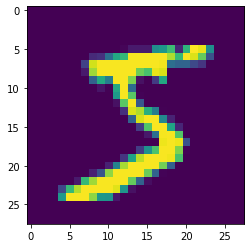

In [27]:
plt.imshow(img.view(28, 28))

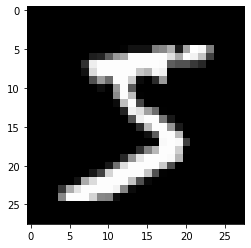

In [28]:
mpl.rcParams['image.cmap'] = 'gray'
plt.imshow(img.view(28, 28))

## Matrix mutiplication
### Using for loops

In [33]:
a = torch.randn(784, 10)
b = torch.zeros(10)

In [68]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    c = torch.zeros(ar, bc)
    for row in range(ar): 
        for col in range(bc): 
            for el in range(ac):
                c[row, col] += a[row, el] * b[el, col]
    
    return c

In [53]:
m1 = x_test[:5]

In [54]:
m1.shape

torch.Size([5, 784])

In [55]:
a.shape

torch.Size([784, 10])

In [69]:
%timeit -n 10 result_1 = matmul(m1, a)

1.08 s ± 7.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [71]:
result_1 = matmul(m1, a)

In [67]:
result.shape

torch.Size([5, 10])

### Using element wise ops

In [73]:
def matmul(a, b): 
    ar, ac = a.shape
    br, bc = b.shape
    c = torch.zeros(ar, bc)
    for row in range(ar): 
        for col in range (bc): 
            c[row, col] = (a[row, :] * b[:, col]).sum()
    
    return c

In [79]:
%timeit -n 10 result_2 = matmul(m1, a)

1.67 ms ± 32.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [81]:
result_2 = matmul(m1, a)

In [83]:
1080 / 1.67

646.7065868263473

In [77]:
#export
def near(a, b): return torch.allclose(a, b, rtol = 1e-3, atol = 1e-5)
def test_near(a, b): test(a, b, near)

In [82]:
test_near(result_1, result_2)

### Broadcasting
#### Trying to understand how squeeze and unsqueeze works

In [90]:
ex_torch = torch.rand(3, 1)

In [91]:
ex_torch

tensor([[0.9362],
        [0.0241],
        [0.8984]])

In [94]:
ex_torch.shape

torch.Size([3, 1])

In [96]:
ex_torch.squeeze(0)

tensor([[0.9362],
        [0.0241],
        [0.8984]])

In [93]:
ex_torch.squeeze(1)

tensor([0.9362, 0.0241, 0.8984])

In [99]:
ex_torch.unsqueeze(0)

tensor([[[0.9362],
         [0.0241],
         [0.8984]]])

In [100]:
ex_torch.unsqueeze(0).shape

torch.Size([1, 3, 1])

In [101]:
ex_torch.unsqueeze(1)

tensor([[[0.9362]],

        [[0.0241]],

        [[0.8984]]])

In [102]:
ex_torch.unsqueeze(1).shape

torch.Size([3, 1, 1])

In [107]:
ex_torch.unsqueeze(1).squeeze(0)

tensor([[[0.9362]],

        [[0.0241]],

        [[0.8984]]])

#### Creating matmul

In [117]:
def matmul(a, b): 
    ar, ac = a.shape
    br, bc = b.shape
    c = torch.zeros(ar, bc)
    for row in range(ar): 
        c[row] = (a[row].unsqueeze(-1) * b).sum(dim=0)
    
    return c

In [122]:
%timeit -n 10 result_3 = matmul(m1, a)

351 µs ± 15.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [123]:
result_3 = matmul(m1, a)

In [124]:
result_3.shape

torch.Size([5, 10])

In [127]:
1130000 / 351

3219.3732193732194

In [125]:
test_near(result_2, result_3)

### Using einstein summation

In [128]:
def matmul(a, b): 
    return torch.einsum("ik,kj->ij", [a, b])

In [130]:
%timeit -n 10 result_4 = matmul(m1, a)

55.1 µs ± 5.54 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [131]:
result_4 = matmul(m1, a)

In [133]:
1130000 / 55.1

20508.166969147005

In [132]:
test_near(result_3, result_4)

### Using pytorch operators

In [134]:
def matmul(a, b): 
    return a@b

In [136]:
%timeit -n 10 result_5 = matmul(m1, a)

8.68 µs ± 2.81 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [137]:
result_5 = matmul(m1, a)

In [139]:
1130000 / 8.68

130184.33179723503

In [138]:
test_near(result_4, result_5)

In [140]:
result_5.shape

torch.Size([5, 10])

### Export

In [144]:
!python notebook2script.py 01_hw_matmul.ipynb

Converted 01_hw_matmul.ipynb to exp\nb_01.py
